In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [99]:
# Set a random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the MLP model
class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    _, actual = torch.max(labels, 1)
    correct = (predicted == actual).sum().item()
    return correct / labels.size(0)

def train_mlp(input_data, labels, val_data, val_labels, hidden_size=10, learning_rate=0.01, epochs=100, seed=42, gpu_device=None, l2_lambda=0.01, depth="shallow"):
    # Set the seed for reproducibility
    set_seed(seed)

    # Set device to the specified GPU if available, otherwise CPU
    if gpu_device is not None and torch.cuda.is_available():
        device = torch.device(f"cuda:{gpu_device}")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    input_size = input_data.shape[1]
    output_size = labels.shape[1]

    # Initialize the model, loss function, and optimizer
    if depth == "shallow":
        model = MLP(input_size, hidden_size, output_size).to(device)
    elif depth == "deep":
        model = DeepMLP(input_size, hidden_size, output_size).to(device)
    else:
        raise Exception("Error in model depth provided.")
    
    criterion = nn.MSELoss()  # Assuming we're doing regression, adjust for classification if needed
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)  # L2 regularization added via weight_decay

    # Convert input data and validation data to PyTorch tensors and move to device
    input_tensor = torch.FloatTensor(input_data).to(device)
    labels_tensor = torch.FloatTensor(labels).to(device)
    val_tensor = torch.FloatTensor(val_data).to(device)
    val_labels_tensor = torch.FloatTensor(val_labels).to(device)

    # Lists to store training and validation losses
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Training loop
    for epoch in range(epochs):
        # Forward pass on training data
        model.train()
        outputs = model(input_tensor)
        loss = criterion(outputs, labels_tensor)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store training loss
        training_losses.append(loss.item())

        # Calculate training accuracy
        train_accuracy = calculate_accuracy(outputs, labels_tensor)
        training_accuracies.append(train_accuracy)

        # Evaluate on the validation set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_outputs = model(val_tensor)
            val_loss = criterion(val_outputs, val_labels_tensor)

        # Store validation loss
        validation_losses.append(val_loss.item())

        # Calculate validation accuracy
        val_accuracy = calculate_accuracy(val_outputs, val_labels_tensor)
        validation_accuracies.append(val_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')
        
    return {"model": model,
            "training_losses": training_losses,
            "validation_losses": validation_losses,
            "training_acc": training_accuracies,
            "validation_acc": validation_accuracies}

In [94]:
# # Example usage:
# # 2D input vectors and 2D output labels for training
# input_data = np.array([[0.5, 0.3], [0.2, 0.8], [0.9, 0.1], [0.7, 0.6]])
# labels = np.array([[0.1, 0.5], [0.4, 0.7], [0.3, 0.2], [0.6, 0.9]])

# # 2D validation vectors and 2D output labels for validation
# val_data = np.array([[0.4, 0.2], [0.3, 0.9]])
# val_labels = np.array([[0.2, 0.4], [0.5, 0.6]])

# # Train the MLP and track validation loss
# model, tl, vl = train_mlp(input_data, labels, val_data, val_labels, hidden_size=5, learning_rate=0.01, epochs=100, seed=42, gpu_device=3)

In [95]:
train_csv_files = ["../data/predator_prey_solution_14_11.csv",
                   "../data/predator_prey_solution_17_57.csv",
                   "../data/predator_prey_solution_24_15.csv",
                   "../data/predator_prey_solution_40_40.csv",
                   "../data/predator_prey_solution_44_52.csv",
                   "../data/predator_prey_solution_58_27.csv"]

training_dataframes = list()
for file in train_csv_files:
    df = pd.read_csv(file)
    training_dataframes.append(df)

data = pd.concat(training_dataframes, ignore_index=True)

training_data = {
    'inputs': data[["Prey", "Predator"]][:-1].to_numpy(),
    'labels': data[["Prey", "Predator"]][1:].to_numpy() 
}
print(training_data['inputs'].shape)

valdata = pd.read_csv('../data/predator_prey_solution_25_72.csv')

validation_data = {
    'inputs': valdata[["Prey", "Predator"]][:-1].to_numpy(),
    'labels': valdata[["Prey", "Predator"]][1:].to_numpy(),
}
print(validation_data['inputs'].shape)

(5999, 2)
(999, 2)


In [98]:
epochs = 10000
seed = 42
l2_lambda = 0.1
lr = 0.01
hidden_size=10000
depth = "deep"
suffix = f"{epochs}-{seed}-{l2_lambda}-{lr}-{hidden_size}-{depth}"

results = train_mlp(training_data['inputs'], 
                  training_data['labels'], 
                  validation_data['inputs'], 
                  validation_data['labels'], 
                  hidden_size=hidden_size, 
                  learning_rate=lr, 
                  epochs=epochs, 
                  seed=seed,
                  gpu_device=3,
                  l2_lambda=l2_lambda,
                  depth=depth)

Using device: cuda:3
Epoch [10/10000], Loss: 463.4454, Validation Loss: 632.2852, Train Acc: 0.8026, Val Acc: 0.9570
Epoch [20/10000], Loss: 39.3751, Validation Loss: 76.1979, Train Acc: 0.7815, Val Acc: 0.9299
Epoch [30/10000], Loss: 22.4302, Validation Loss: 48.8651, Train Acc: 0.8913, Val Acc: 0.9520
Epoch [40/10000], Loss: 13.9450, Validation Loss: 24.8086, Train Acc: 0.7885, Val Acc: 0.9429
Epoch [50/10000], Loss: 11.9828, Validation Loss: 29.4372, Train Acc: 0.8433, Val Acc: 0.9610
Epoch [60/10000], Loss: 10.2339, Validation Loss: 27.8757, Train Acc: 0.8488, Val Acc: 0.9800
Epoch [70/10000], Loss: 10.3963, Validation Loss: 45.5045, Train Acc: 0.8411, Val Acc: 0.9520
Epoch [80/10000], Loss: 8.9344, Validation Loss: 32.1826, Train Acc: 0.8680, Val Acc: 0.9489
Epoch [90/10000], Loss: 8.9945, Validation Loss: 21.3263, Train Acc: 0.8905, Val Acc: 0.9429
Epoch [100/10000], Loss: 8.8764, Validation Loss: 25.7515, Train Acc: 0.8723, Val Acc: 0.9119
Epoch [110/10000], Loss: 15.3436, Valid

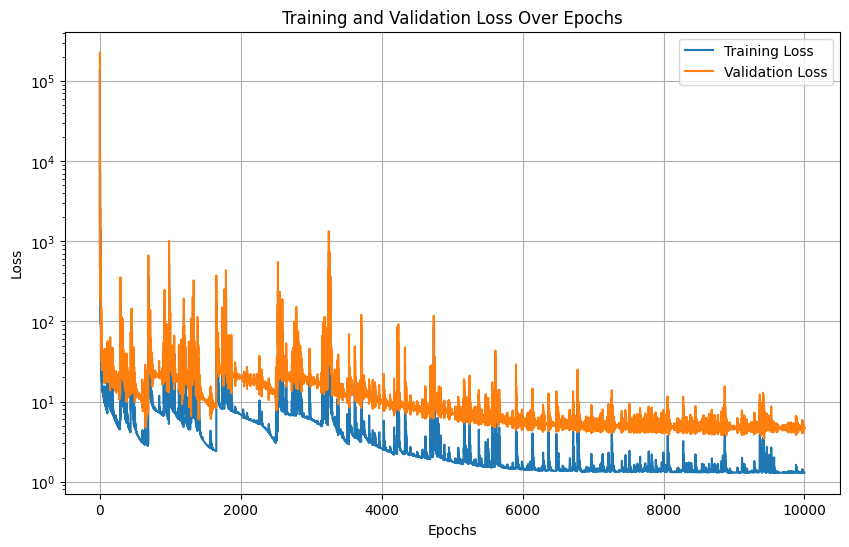

In [100]:
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results["training_losses"], label='Training Loss')
plt.plot(range(epochs), results["validation_losses"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.savefig(f'../results/pp_mlp_loss_{suffix}.png')

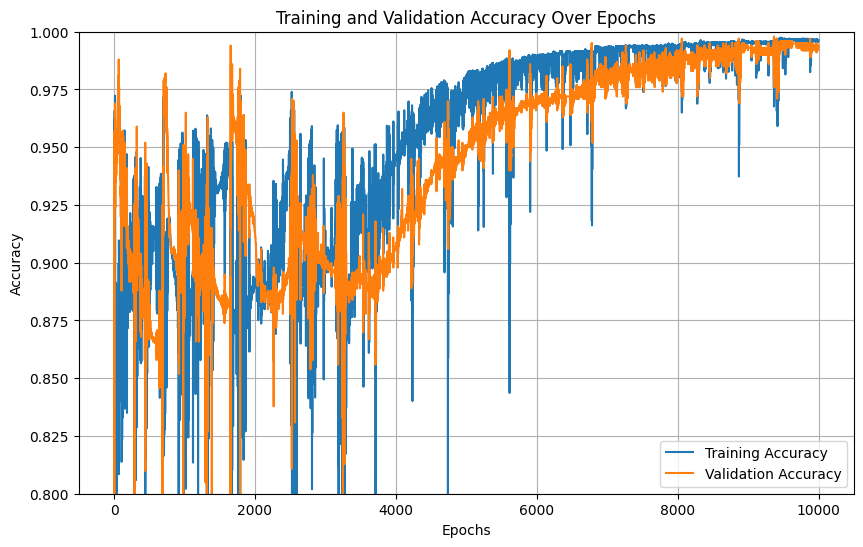

In [101]:
# Plot the training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), results["training_acc"], label='Training Accuracy')
plt.plot(range(epochs), results["validation_acc"], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.savefig(f'../results/pp_mlp_acc_{suffix}.png')